<a href="https://colab.research.google.com/github/Hrenani/DL_Project/blob/main/Age_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir=rtl>
  <strong>بیان مسئله</strong><br>
  هدف از انجام این پروژه تخمین سن از روی عکس چهره افراد هست . میدانیم به دلیل تفاوت نژادی، آرایش ، سبک زندگی و ... این موضوع میتواند چالش برانگیز باشد .
  <br>
  <strong>هدف از حل مسئله</strong>
  <br>
  1. آموزش یک شبکه عصبی با پایتورچ برای تخمین سن
  <br>
  2. مقاوم بودن این تصویر به نور یا تصویر های کم کیفیت
  <br>
  3. مقاوم نسبت به نژاد و ...
</div>

<div dir=rtl>
<strong> انتخاب روش حل مسئله</strong><br>
با بررسی هایی که انجام دادم روش های مختلفی قبلا پیاده سازی شده برای حل این پروژه مثلا:<br>
1.استفاده از رگرسیون و کانولوشن<br>
2.استفاده از کلسیفیکیشن و کانولوشن<br>
3.توسعه دادن یک لایبری برای این کار <br>
4.miVolo<br>
<br>
روش سوم یکم پیچیده بود و  احتمال دادم (درواقع مطئمن بودم) تا زمان اتمام پروژه نتوانم به آن برسم. روش  چهارم هم  خیلی جالب بود حتی میشد فقط از چهر استفاده نکرد و از مو، دست و دیگر اعضا بدن برای تخمین سن استفاده کرد اما باتوجه به محدودیت زمانی و سخت افزاری که داشتم تصمیم گرفتم از روش اول استفاده کنم.
</div>

<div dir = rtl>
اول کتاب خانه torchmetrics را نصب میکنم سپس بقیه کتابخانه ها را وارد میکنم.
<div>

In [ ]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2 as cv
import PIL
from PIL import Image

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import tqdm
import torchmetrics as tm

In [ ]:
for lib in [np, pd, cv, PIL, sklearn, torch, torchvision, tqdm, tm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
pandas --> 2.1.4
cv2 --> 4.10.0
PIL --> 9.4.0
sklearn --> 1.3.2
torch --> 2.3.1+cu121
torchvision --> 0.18.1+cu121
tqdm --> 4.66.5
torchmetrics --> 1.4.1


<div dir=rtl>
دیتاست را از گوگل درایوی که قرار دادم لود میکنم.
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf '/content/drive/MyDrive/datas/UTKFace/UTKFace.tar.gz' -C '/content/'

<div dir=rtl>
<strong>تحلیل اکتشافی داده(EDA)</strong><br>
اول داده ها را برای کشیدن نمودار و .. آماه میکنم.
</div>

In [ ]:
dataset_dir = "/content/UTKFace"

image_name = []
ages = []
genders = []
ethnicitys = []

for filename in os.listdir(dataset_dir):
  if filename.endswith(".jpg"):
    parts = filename.split("_")
    if len(parts) < 4:
      print(filename)
      continue

    age = int(parts[0])
    gender = "Male" if int(parts[1]) == 0 else "Female"
    ethnicity = ["White", "Black", "Asian", "Indian", "Others"][int(parts[2])]
    image_name.append(filename)
    ages.append(age)
    genders.append(gender)
    ethnicitys.append(ethnicity)

data = {
    "image_name": image_name,
    "age": ages,
    "gender": genders,
    "ethnicity": ethnicitys
}

CSV_filename = '/content/UTKFace.csv'
df = pd.DataFrame(data)
df.to_csv(CSV_filename, index=False)

print(f"CSV file{CSV_filename} created seccessfully")

61_1_20170109150557335.jpg.chip.jpg
61_1_20170109142408075.jpg.chip.jpg
39_1_20170116174525125.jpg.chip.jpg
CSV file/content/UTKFace.csv created seccessfully


<div dir=rtl>
همان طور که در نتیجه سلول بالا مشاهده میشود سه مورد را داریم که ساختارش درست نیست و در کد csv ما قرار نمیگیرد.
</div>

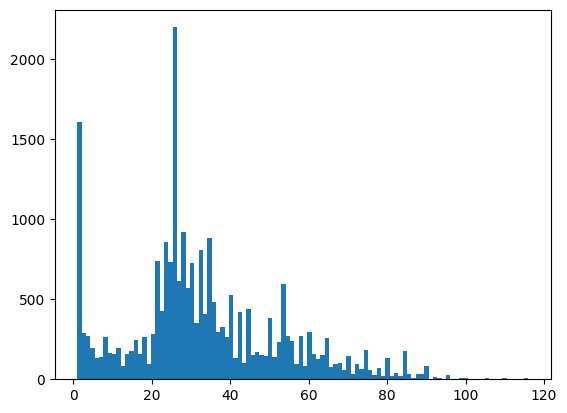

In [ ]:
plt.hist(ages , bins = len(df.age.unique()));

<div dir=rtl>
نمودار بالا نشان میدهد که توزیع سن یکسان نیست و از بعضی سن ها که مشخص هست بیشتر نمونه داریم و از بعضی خیلی کمتر.
</div>

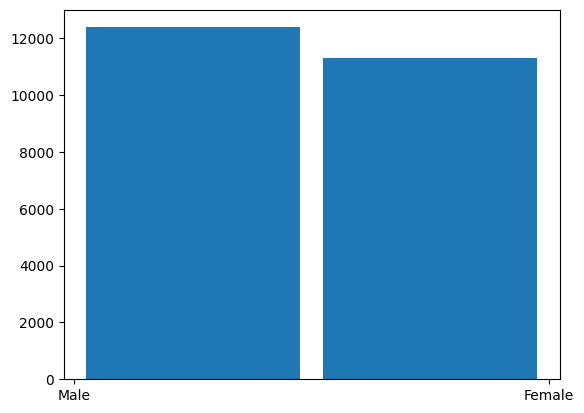

In [ ]:
plt.hist(genders, bins = len(df.gender.unique()),rwidth=.9);

<div dir=rtl>
از نمودار بالا میشود فهمید که جنیست ها تقریبا(نه کاملا) تعادل خوبی دارند .
</div>

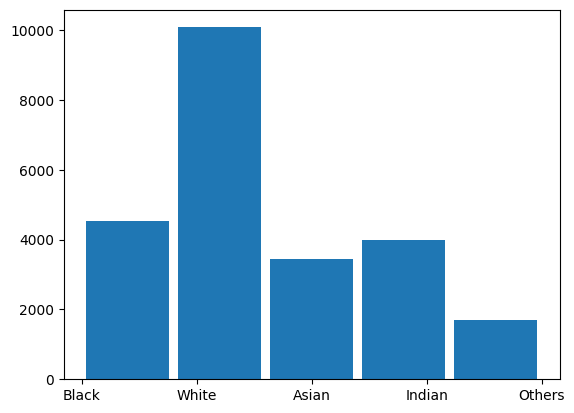

In [ ]:
plt.hist(df.ethnicity, len(df.ethnicity.unique()), rwidth=.9);

<div dir=rtl>
چیزی که از نمودار بالا قابل توجه هست این هست که تقریبا نصف داه های مارا سفید پوست ها تشکیل میدهند.

</div>

In [ ]:
pd.crosstab(df.gender, df.ethnicity)

ethnicity,Asian,Black,Indian,Others,White
gender,,,,,
Female,1859,2208,1714,932,4601
Male,1575,2318,2261,760,5477


<div dir=rtl>
از جدول بالا اطلاعات زیادی میتوان به دست آورد که به چند تا اشاره میکنم مثلا اینکه تعد سفید پوستان مرد تقریبا هزارتا بیشتر از سفید پوستان زن هست یا اینکه تعد "دیگران " در خانم ها بیشتر از آقایون هست و ...
</div>

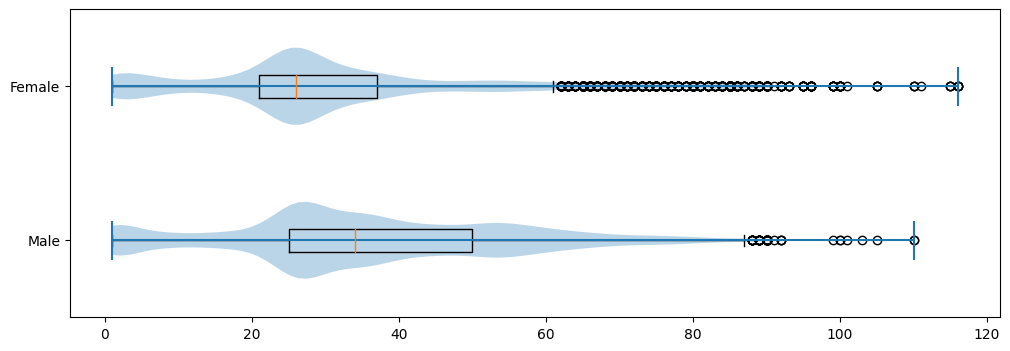

In [ ]:
plt.figure(figsize = (12,4))
plt.boxplot([df.age[df.gender == cat] for cat in df.gender.unique()] , vert = False ,labels = df.gender.unique());
plt.violinplot([df.age[df.gender == cat] for cat in df.gender.unique()] , vert = False);

<div dir=rtl>
میتوان از نمودار بالا نتیجه گرفت مرد ها اکثرا در سن 20 تا 60 سال هستند و خانم ها اکثرا در سن 20 تا 40 سال
</div>

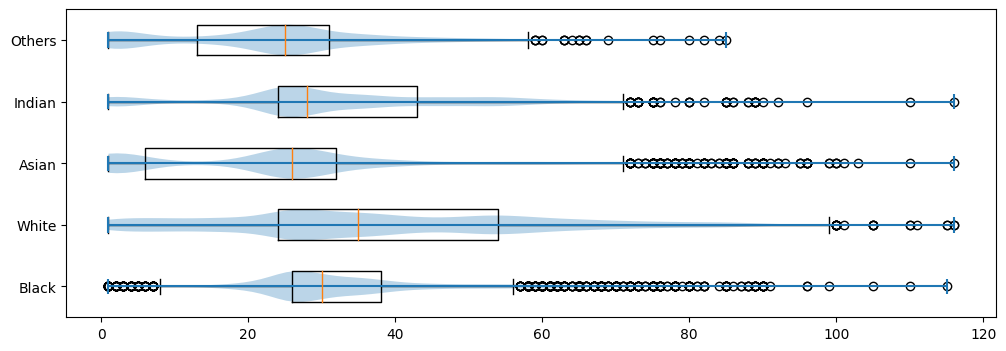

In [ ]:
plt.figure(figsize = (12,4))
plt.boxplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()] , vert = False ,labels = df.ethnicity.unique());
plt.violinplot([df.age[df.ethnicity == cat] for cat in df.ethnicity.unique()] , vert = False);

<div dir=rtl>
نتیجه ای که از این نمودار میتوان گرفت این هست که توزیع سن برای سفید پوستان خیلی بهتر از بقیه هست ولی برای سیاه پوستان بد تر از بقیه هست همچنین میانگین سنی other کمتر از بقیه هست همچنین باتوجه به باکس پلات سن اکثر آسیایی ها  کم هست.
</div>

<br>
<br>
<div dir=rtl>
<strong><strong>تقسیم بندی دیتاست</strong></strong><br>
دیتاست را باید به سه قسمت train, valid, test تقسیم بندی کنیم.
</div>

In [ ]:
df_corrected = df.groupby('age').filter(lambda x: len(x) > 1)  # when i run this cell without this line I have error becuase I use stratiry and there is one sample from df.age (for example just one picture at age 100) and this is wrong for stratiry.
df_train, df_test_valid = train_test_split(df_corrected, test_size=0.3,stratify=df_corrected.age, random_state=42)

df_test_valid = df_test_valid.groupby('age').filter(lambda x: len(x) > 1)
df_test, df_valid = train_test_split(df_test_valid, test_size=0.5,stratify=df_test_valid.age, random_state=42)
df_train.shape, df_test.shape, df_valid.shape

((16592, 4), (3552, 4), (3552, 4))

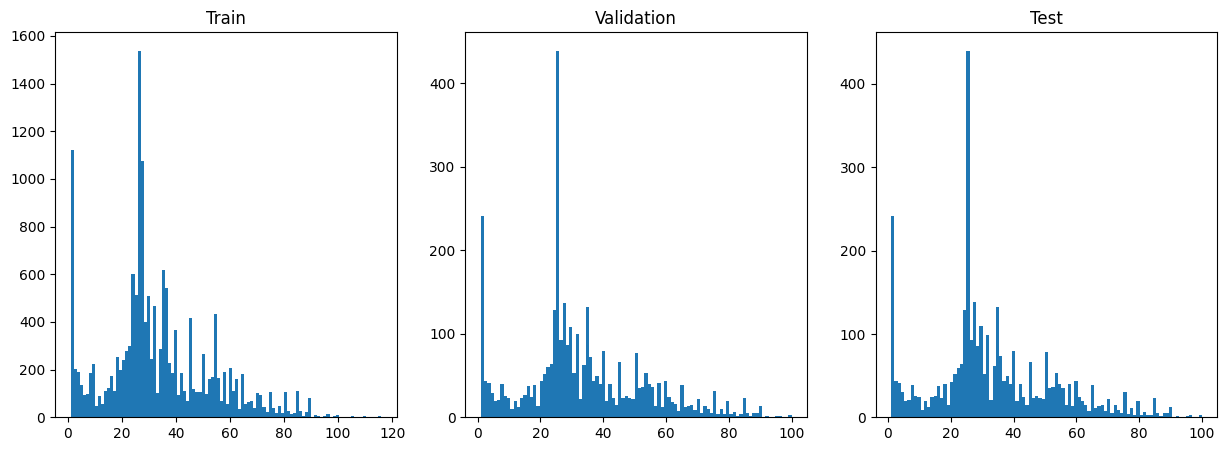

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train.age, bins=len(df_train.age.unique())); axes[0].set_title('Train')
axes[1].hist(df_valid.age, bins=len(df_valid.age.unique())); axes[1].set_title('Validation')
axes[2].hist(df_test.age, bins=len(df_test.age.unique())); axes[2].set_title('Test');

<div dir=rtl>
همان طور که انظار میرفت توزیع ها طبق کدی که زدیم یکسان به دست آمده برای هر سه دسته.
</div>

In [ ]:
df_train.to_csv('/content/train_set.csv', index=False)
df_valid.to_csv('/content/valid_set.csv', index=False)
df_test.to_csv('/content/test_set.csv', index=False)

<div dir=rtl>
در سل بالا سه دیتاست که ایجاد کردیم را در فایل های csv ذخیره میکنیم.
</div>

<br>
<div dir=rtl>
براساس سرچ هایی که کردم و اطلاعاتی که به دست آوردم transform خودم را مینویسم تا از آن بعدا استفاده کنم.
</div>

In [ ]:
train_tranform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness = 0.2,contrast = 0.2, saturation = 0.2,hue = 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
class UTKDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
      self.root_dir = root_dir
      self.csv_file = csv_file
      self.transform = transform
      self.data = pd.read_csv(csv_file)
      self.gender_dict = {'Male': 0, 'Female': 1}

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      sample = self.data.iloc[idx,:]

      img_name = sample.image_name
      img = Image.open(os.path.join(self.root_dir, img_name))

      age = torch.tensor([sample.age], dtype = torch.float32)
      gender = torch.tensor(self.gender_dict[sample.gender], dtype = torch.int32)
      ethnicity = sample.ethnicity

      img = self.transform(img)
      return img, age, gender, ethnicity

<div dir=rtl>
در سل بالا کاستوم دیتاست خودم را نوشتم
</div>

In [ ]:
train_set = UTKDataset(root_dir = dataset_dir, csv_file = '/content/train_set.csv', transform=train_tranform)
valid_set = UTKDataset(root_dir = dataset_dir, csv_file = '/content/valid_set.csv', transform=test_transform)
test_set = UTKDataset(root_dir = dataset_dir, csv_file = '/content/test_set.csv', transform=test_transform)

<div dir=rtl>
در سل بالا از به وسیله کاستوم دیتاستی که نوشتم از دیتاستم نمونه ایجاد میکنم تا از آن استفاده کنم.
</div>

In [ ]:
train_loader = DataLoader(train_set, batch_size = 128, shuffle=True)
test_loader = DataLoader(test_set, batch_size = 256, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size = 256, shuffle=False)

<div dir=rtl>
در سل بالا از هرکدام از سه قسمت داده ای که دارم دیتالودر ایجاد کردم.
</div>

In [ ]:
train_iter = iter(train_loader)
train_iter

In [ ]:
imgs, ages, _ ,_ = next(train_iter)
imgs.shape, ages.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128, 1]))

In [ ]:
class AgeEstimationModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    self.model.fc = nn.Linear(in_features=2048, out_features=1, bias = True)

  def forward(self, x):
    y = self.model(x)
    return y

<div dir=rtl>
در سل بالا مدل خودم را نوشتم و در آن از resnet50 استفاده کردم.
</div>

In [ ]:
model = AgeEstimationModel()
model(imgs).shape

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


torch.Size([128, 1])

<div dir=rtl>
از مدل آبجکت ساختم.
</div>

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
loss_fn = nn.L1Loss()
loss_fn

L1Loss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.02, momentum=0.9,weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.02
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0.0001
)

In [ ]:
metric = tm.MeanAbsoluteError().to(device)
metric

MeanAbsoluteError()

<div dir=rtl>
بهینه ساز، تابع ضرر و معیارها را در این بخش تعریف کردم.
</div>

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

<div dir=rtl>
این کلاس میانگین و مقدار فعلی را محاسبه و ذخیره می کند (کار ما را در نوشتن تابع train راحت تر میکند.)
</div>

<br><div dir=rtl><strong>
تابع Train
</strong></div>

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit = 'batch') as tepoch:
    for inputs, targets,_,_ in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n= len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss = loss_train.avg, metric =metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

<br><div dir=rtl><strong>
تابع validation
</strong></div>

In [ ]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets,_,_ in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)
      loss_eval.update(loss.item(), n= len(targets))

      metric.update(outputs, targets)

  return loss_eval.avg, metric.compute().item()

In [ ]:
evaluate(model, test_loader, loss_fn, metric)

(33.113893182428036, 33.1138916015625)

<br><div dir=rtl><strong>
به دست آوردن هایپرپارامترها
</strong></div>

In [ ]:
model = AgeEstimationModel().to(device)

inputs,targets,_,_ = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)

print(loss)

tensor(33.4234, device='cuda:0')


In [ ]:
torch.cuda.empty_cache()

temp = torch.tensor(1, device=device)
model = temp.clone()
optimizer = temp.clone()
inputs = temp.clone()
targets = temp.clone()
outputs = temp.clone()

In [ ]:
num_epoch = 1

for lr in [0.1,0.01,0.001,0.0001]:
  print(f'Lr={lr}')

  model = AgeEstimationModel().to(device)
  optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)

  for epoch in range(num_epoch):
    model,_,_ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

Lr=0.1


100%|██████████| 130/130 [02:15<00:00,  1.04s/batch, loss=15.1, metric=15.1]



Lr=0.01


100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=11.8, metric=11.8]



Lr=0.001


100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=15.7, metric=15.7]



Lr=0.0001


100%|██████████| 130/130 [02:11<00:00,  1.01s/batch, loss=31.9, metric=31.9]

In [ ]:
num_epoch = 3

for lr in [0.05,0.01]:
  for wd in [1e-4,1e-5]:
    print(f"lr={lr}, wd={wd}")

    model = AgeEstimationModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=wd)

    for epoch in range(num_epoch):
      model,loss,_ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

lr=0.05, wd=0.0001


Epoch 2: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=8.51, metric=8.51]



lr=0.05, wd=1e-05


Epoch 2: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=8.77, metric=8.77]



lr=0.01, wd=0.0001


Epoch 2: 100%|██████████| 130/130 [02:08<00:00,  1.01batch/s, loss=6.49, metric=6.49]



lr=0.01, wd=1e-05


Epoch 2: 100%|██████████| 130/130 [02:11<00:00,  1.01s/batch, loss=6.36, metric=6.36]

<div dir =rtl>
برای به دست آوردن مقادیر اولیه مناسب از lr و wd باید محدوده بیشتری را امتحان میکردم ولی متاسفانه از آنجا که مدام کولب gpu را از من میگرفت مجبور شدم این بازه را محدود کنم.
</div>

<br><div dir=rtl><strong>
آموزش  دادن مدل
</strong></div>

In [ ]:
model = AgeEstimationModel().to(device)

In [ ]:
lr = 0.01
wd = 1e-05
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  model, loss_train, metric_train = train_one_epoch(model,train_loader,loss_fn,optimizer,metric,epoch)

  loss_valid, metric_valid = evaluate(model,valid_loader,loss_fn,metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, MAE = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 130/130 [02:18<00:00,  1.06s/batch, loss=4.41, metric=4.41]


Model Saved!
Valid: Loss = 5.188, MAE = 5.188



Epoch 1: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=4.33, metric=4.33]


Model Saved!
Valid: Loss = 5.028, MAE = 5.028



Epoch 2: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=4.21, metric=4.21]


Valid: Loss = 5.232, MAE = 5.232



Epoch 3: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=4.18, metric=4.18]


Model Saved!
Valid: Loss = 4.938, MAE = 4.938



Epoch 4: 100%|██████████| 130/130 [02:06<00:00,  1.02batch/s, loss=4.1, metric=4.1]


Valid: Loss = 5.185, MAE = 5.185



Epoch 5: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=4.01, metric=4.01]


Valid: Loss = 5.105, MAE = 5.105



Epoch 6: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=3.88, metric=3.88]


Valid: Loss = 5.028, MAE = 5.028



Epoch 7: 100%|██████████| 130/130 [02:07<00:00,  1.02batch/s, loss=3.91, metric=3.91]


Valid: Loss = 5.034, MAE = 5.034



Epoch 8: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=3.7, metric=3.7]


Valid: Loss = 4.985, MAE = 4.985



Epoch 9: 100%|██████████| 130/130 [02:06<00:00,  1.03batch/s, loss=3.72, metric=3.72]


Valid: Loss = 4.981, MAE = 4.981



<br><div dir=rtl><strong>
کشیدن learning curve
</strong></div>

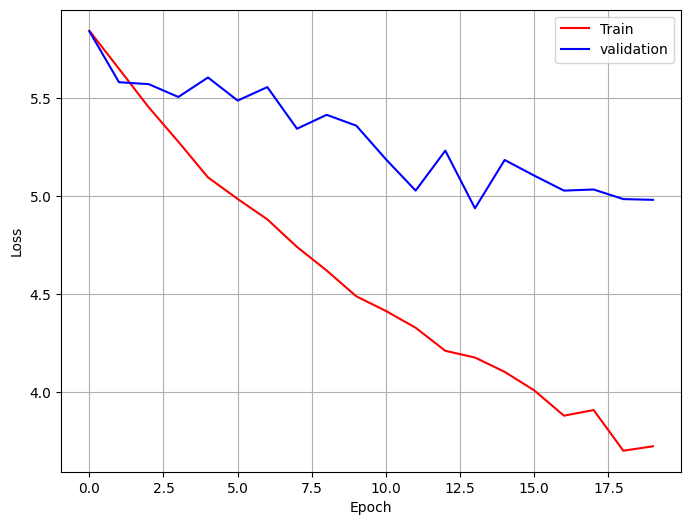

In [ ]:
plt.figure(figsize = (8,6))

plt.plot(range(epoch_counter), loss_train_hist , 'r-', label = 'Train')
plt.plot(range(epoch_counter), loss_valid_hist , 'b-', label = 'validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

<div dir =rtl>
همان طور که در شکل مشخص هست کمترین لاس در داده ارزیابی تقریبا برای ایپاگ 13 هست و از آنجا به بعد تا تقریبا کمی از ایپاک 14 اورفیت داریم بعد لاس کم میشود ولی باز هم کمترین لاس برای همان ایپاک 13 هست و بهتر بود اینجا فرایند آموزش را متوفق میکردیم.
همچنین مدل در داده های ارزبابی(validation) عملکرد ضعیف تری نسبت به داده های آموزش  دارد.
</div>

<br><div dir=rtl><strong>
تست مدل
</strong></div>

In [ ]:
model_path = '/content/model.pt'
model = torch.load(model_path)
model.eval()

AgeEstimationModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [ ]:
_, metric_train = evaluate(model, train_loader, loss_fn, metric)
_, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
_, metric_test = evaluate(model, test_loader, loss_fn, metric)

metric_train, metric_valid, metric_test

(3.9086713790893555, 4.938115119934082, 5.0370097160339355)

<br><div dir=rtl><strong>
تابع inference
</strong></div>

In [ ]:
!pip install face-recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=fca9d9907e13eb03f02b58cb188ffc507eb9d35a3427356fbab38633f262bd7c
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import face_recognition

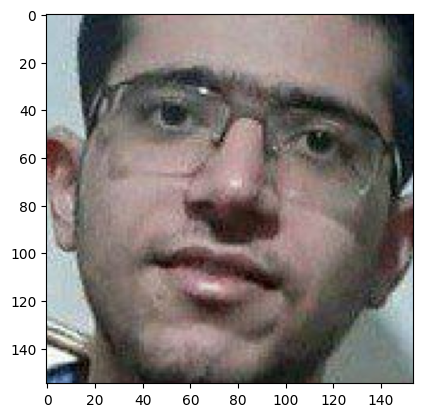

In [ ]:
img = face_recognition.load_image_file('/content/Hosein_ghorbani.jpg')
top, right, bottom, left = face_recognition.face_locations(img)[0]
img_crop = img[top:bottom, left:right]
plt.imshow(img_crop);

In [ ]:
img_crop = Image.fromarray(img_crop)
img_tensor = test_transform(img_crop).unsqueeze(0)
img_tensor.shape

torch.Size([1, 3, 128, 128])

In [ ]:
with torch.inference_mode():
  preds = model(img_tensor.to(device)).item()
preds

23.690767288208008

In [ ]:
def inference(image_path, transform, model, face_detection=False):
  if face_detection:
    img = face_recognition.load_image_file(image_path)
    top, right, bottom, left = face_recognition.face_locations(img)[0]
    img_crop = img[top:bottom, left:right]
    img_crop = Image.fromarray(img_crop)
  else:
    img_crop = Image.open(image_path).convert('RGB')

  img_tensor = transform(img_crop).unsqueeze(0)
  with torch.inference_mode():
    preds = model(img_tensor.to(device)).item()

  return preds, img_crop

23.69


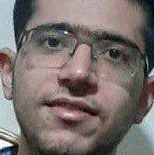

In [ ]:
preds, img = inference('/content/Hosein_ghorbani.jpg',test_transform, model, face_detection = True)

print(f'{preds:.2f}')
img

Real: 46, Predicted: 46.40


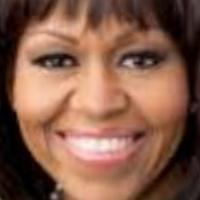

In [ ]:
folder_image_path = '/content/UTKFace/'
image_files = os.listdir(folder_image_path)

rand_idx = random.randint(0, len(image_files))
test_image_path = os.path.join(folder_image_path, image_files[rand_idx])
predicted_age, image = inference(test_image_path, test_transform, model)

real_age = image_files[rand_idx].split('_')[0]
print(f"Real: {real_age}, Predicted: {predicted_age:.2f}")
image